### DN1 - Naloga 3
Avtor: Urh Primožič

Podatke uvozim in razdelim. Ker bom uporabljal knn, jih bom še reskaliral.

In [3]:
import pandas as pd #cvs importing
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('podatki_DN1_2.csv', header=0)
columns = df.columns[1:] #1. stolpec je le dekoracijski
df = df[columns]
X = df[['x1', 'x2', 'x3', 'x4']]
y = df['y']
# pretvorim y v {0, 1}, ker lažje delam s tem
y = y.map(lambda x : 1 if x== 'da' else 0) 

# vrednosti v X spravim na (0,1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#razdelim podatke
RANDOM_SEED = 420 # da mi med testiranjem doma vedno da enake rezultate
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3/4, stratify=y, random_state= RANDOM_SEED)


Radi bi pravilno zaznali čim več enic in imeli čim manj lažno negativnih (ničelnih). Torej hočemo čim večji priklic. 

In [44]:
from sklearn.metrics import RocCurveDisplay, recall_score, accuracy_score, precision_score, roc_auc_score, roc_curve

k_range = list(range(1, 50))
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range)
# grid with 10 folkd cross validation
grid = GridSearchCV(knn, param_grid,  cv=5, scoring='recall')
grid.fit(X_train, y_train)

print('Priklic: ', grid.best_score_)
print('Optimalni parametri: ', grid.best_params_)
print(f"Točnost modela je {accuracy_score(y_train, grid.predict(X_train))} na učni in {accuracy_score(y_test, grid.predict(X_test))} na testni.")
print(f"Priklic modela je {recall_score(y_train, grid.predict(X_train))} na učni in {recall_score(y_test, grid.predict(X_test))} na testni.")
print(f"Preciznost modela je {precision_score(y_train, grid.predict(X_train))} na učni in {precision_score(y_test, grid.predict(X_test))} na testni.")




Priklic:  0.6952380952380952
Optimalni parametri:  {'n_neighbors': 7}
Točnost modela je 0.9426666666666667 na učni in 0.924 na testni.
Priklic modela je 0.7037037037037037 na učni in 0.6944444444444444 na testni.
Preciznost modela je 0.8735632183908046 na učni in 0.7575757575757576 na testni.


ROC krivulja

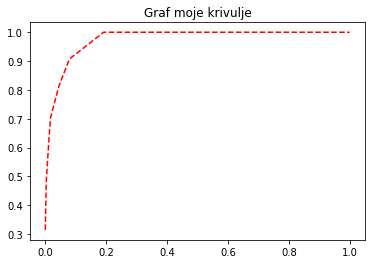

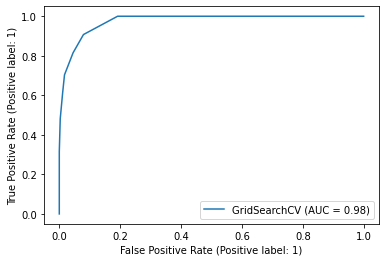

In [49]:
import matplotlib.pyplot as plt
# moja implementacija


def ROC_curve(X, y, model):
    '''
    Izračuna možne  tresholde
    Parametri
    ----------
    - X, y - podatki
    - model - model z metodo predict_proba()
    '''
    
    # možne thete
    # dokumentacija: moreš vzet higher label za probabilities
    thetas = model.predict_proba(X)[:, 1]
    TPRs = []
    FPRs = []
    for theta in thetas:
        P = np.sum(y)
        N = len(y)  - P
        predictions = np.array(
            list(map(lambda x: 1 if x >= theta else 0, thetas)))
        positive_y = predictions[y == 1]
        TP = np.sum(positive_y == 1)
        FP = np.sum(predictions) - TP

        TPR = TP/P
        FPR = FP/N
        TPRs.append(TPR)
        FPRs.append(FPR)
    return [FPRs, TPRs]


# nariši ROC
tocke = ROC_curve(X_train, y_train, grid)

# sorting točk, da mi yplot lepo poveže
sorted_list = sorted(range(len(tocke[0])), key=lambda a: tocke[0][a])
tocke_x = [tocke[0][i] for i in sorted_list]
tocke_y = [tocke[1][i] for i in sorted_list]
plt.plot(tocke_x, tocke_y, 'r--')
plt.title('Graf moje krivulje')
plt.show()
RocCurveDisplay.from_estimator(grid, X_train, y_train)

Krivulji sta enaki. Izračunajmo še ploščino.

In [50]:
def trapezna_metoda_za_pozitivne(tocke_x, tocke_y):
    S = 0
    x0, y0 = tocke_x[0], tocke_y[0]
    for i  in range(len(tocke_x)):
        x = tocke_x[i]
        y = tocke_y[i]
        dx = x - x0 
        dy = y - y0
        S += dx*y0 + 0.5 * dx*dy
        x0, y0 = x, y
    return S 
AOC_moje = trapezna_metoda_za_pozitivne(tocke_x, tocke_y)
AUC_prava = roc_auc_score(y_train, grid.predict_proba(X_train)[:,1])
print(f"AOC po moji metodi je {AOC_moje}, po metodi iz scikit-learn pa {AUC_prava}.")

AOC po moji metodi je 0.9757557401638399, po metodi iz scikit-learn pa 0.9757557401638399.


In [48]:
q = []
prev = -1
for i in tocke_x:
    if i!= prev:
        q.append(prev)
    prev = i
q = q[1:]
print(q)

roc_curve(y_train, grid.predict_proba(X_train)[:,1])

[0.0, 0.0026666666666666666, 0.009333333333333334, 0.014666666666666666, 0.03866666666666667, 0.068, 0.164]


(array([0.        , 0.        , 0.00311526, 0.01090343, 0.01713396,
        0.04517134, 0.07943925, 0.19158879, 1.        ]),
 array([0.        , 0.31481481, 0.48148148, 0.61111111, 0.7037037 ,
        0.81481481, 0.90740741, 1.        , 1.        ]),
 array([2.        , 1.        , 0.85714286, 0.71428571, 0.57142857,
        0.42857143, 0.28571429, 0.14285714, 0.        ]))